# Genpact Machine Learning Hackathon

<img src='../images/problem_statement.png'>
<img src='../images/data_dict.png'>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
import gc
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [0]:
#pd.set_option('display.max_rows', None)
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [0]:
FILES_PATH = '../input/'
SUB_PATH = '../submissions/'

In [0]:
fci_df = pd.read_csv(f"{FILES_PATH}/fulfilment_center_info.csv")
mi_df = pd.read_csv(f"{FILES_PATH}/meal_info.csv")
train_df = pd.read_csv(f"{FILES_PATH}/train.csv")
test_df = pd.read_csv(f"{FILES_PATH}/test.csv")
sub_df = pd.read_csv(f"{FILES_PATH}/sample_submission.csv")

In [0]:
# head of fulfilment_center_info file
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [0]:
print("Shape of fulfilment_center_info :", fci_df.shape)

Shape of fulfilment_center_info : (77, 5)


In [0]:
# NaN values in fulfilment_center_info
fci_df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [0]:
# head of meal_info file
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [0]:
print("Shape of meal_info: ", mi_df.shape)

Shape of meal_info:  (51, 3)


In [0]:
# NaN values in meal_info
mi_df.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [0]:
# Head of Train file (historical demand data)
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [0]:
print("Shape of train: ", train_df.shape)

Shape of train:  (456548, 9)


In [0]:
# NaN values in train data
train_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [0]:
# Head of Test data
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [0]:
print("Shape of Test: ", test_df.shape)

Shape of Test:  (32573, 8)


In [0]:
# NaN values in test data
test_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [0]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [19]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [0]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'

In [0]:
train_df['num_orders'] = np.log1p(train_df['num_orders'])

In [0]:
all_df = train_df.append(test_df).reset_index(drop=True)[train_df.columns]

In [0]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [0]:
all_df['checkout_price'] = np.log1p(all_df['checkout_price'])
all_df['base_price'] = np.log1p(all_df['base_price'])

In [0]:
all_df['discount_on_base'] = (all_df['base_price'] - all_df['checkout_price']) / all_df['base_price']

In [52]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095


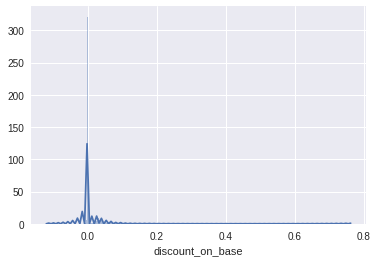

In [53]:
sns.distplot(all_df['discount_on_base'], bins=500)
plt.show()

In [0]:
all_df['neg_discount'] = (all_df['discount_on_base'] < 0).astype(int)

In [0]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)

In [0]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()

In [0]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)

In [0]:
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)

In [59]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082,1,-0.001037,1
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043,0,0.002077,0
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095,1,-0.001075,1


#### Some functions to create aggregated, rolling mean/median, and exponentially weighted features.

Code from : https://www.kaggle.com/abhilashawasthi/feature-engineering-lgb-model

In [0]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [0]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [0]:
def one_hot_encoder(df, ohe_cols):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [0]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
all_df = create_sales_lag_feats(all_df, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11, 12])

## all_df = create_sales_rmean_feats(all_df, gpby_cols=['center_id','meal_id'], 
##                                 target_col='num_orders', windows=[26,52,104], 
##                                 min_periods=3, win_type='triang')

## all_df = create_sales_rmed_feats(all_df, gpby_cols=['center_id','meal_id'], 
##                                 target_col='num_orders', windows=[26,52,104], 
##                                 min_periods=3, win_type=None)

all_df = create_sales_ewm_feats(all_df, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.5], 
                               shift=[10,11,12,13,14,15])


In [61]:
all_df.shape

(489121, 29)

In [62]:
show_all(all_df, 5, None)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489119,1429037,115,186,2956,6.366522,6.369952,0,0,2.772589,649,34,TYPE_A,3.4,Fish,Continental,train,0.000539,0,0.000539,0,2.718912,4.374945,2.063380,3.097631,3.556204,3.398836,3.430377,3.564916,3.392163
489120,1285049,116,186,2956,5.680275,6.368239,0,0,4.812184,649,34,TYPE_A,3.4,Fish,Continental,train,0.108030,0,0.107790,0,3.014780,0.568905,3.441018,3.405601,3.097631,3.556204,3.398836,3.430377,3.564916


In [0]:
trn = all_df.loc[all_df['train_or_test']=='train', :]
test = all_df.loc[all_df['train_or_test']=='test', :]

In [70]:
trn.shape

(456548, 29)

In [71]:
test.shape

(32573, 29)

In [77]:
trn.isnull().sum()

id                               0
week                             0
center_id                        0
meal_id                          0
checkout_price                   0
base_price                       0
emailer_for_promotion            0
homepage_featured                0
num_orders                       0
city_code                        0
region_code                      0
center_type                      0
op_area                          0
category                         0
cuisine                          0
train_or_test                    0
discount_on_base                 0
neg_discount                     0
price_last_curr_diff             0
price_increase                   0
num_orders_lag_10            35843
num_orders_lag_11            39412
num_orders_lag_12            42980
num_orders_lag_10_ewm_0.5       10
num_orders_lag_11_ewm_0.5       11
num_orders_lag_12_ewm_0.5       12
num_orders_lag_13_ewm_0.5       13
num_orders_lag_14_ewm_0.5       14
num_orders_lag_15_ew

### Catboost

In [0]:
avoid_columns1 = ['id', 'num_orders', 'train_or_test', 'checkout_price', 'base_price', 'city_code', 'region_code', 'center_type', '']

In [0]:
features1 = [col for col in test.columns if col not in avoid_columns1]

In [74]:
features1

['week',
 'center_id',
 'meal_id',
 'emailer_for_promotion',
 'homepage_featured',
 'op_area',
 'category',
 'cuisine',
 'discount_on_base',
 'neg_discount',
 'price_last_curr_diff',
 'price_increase',
 'num_orders_lag_10',
 'num_orders_lag_11',
 'num_orders_lag_12',
 'num_orders_lag_10_ewm_0.5',
 'num_orders_lag_11_ewm_0.5',
 'num_orders_lag_12_ewm_0.5',
 'num_orders_lag_13_ewm_0.5',
 'num_orders_lag_14_ewm_0.5',
 'num_orders_lag_15_ewm_0.5']

In [0]:
cat_ind1 = [1, 2, 3, 4, 6, 7, 9, 11]

In [0]:
cat_rg1 = cb.CatBoostRegressor(iterations=625, learning_rate=0.06, depth=8, l2_leaf_reg=10, loss_function='RMSE', random_seed=2018)

In [ ]:
cat_rg1.fit(X=trn[features1], y=trn['num_orders'], cat_features=cat_ind1, verbose=True)

624:	learn: 0.4839052	total: 8m 15s	remaining: 0us

In [0]:
pred = cat_rg1.predict(test[features1])

In [0]:
pred = (np.exp(pred) - 1)

In [0]:
sub_df = pd.DataFrame(columns=['id', 'num_orders'])
sub_df['id'] = test['id']
sub_df['num_orders'] = pred
sub_df.to_csv(f'{SUB_PATH}/cat10.csv', index=False)

In [0]:
# for catboost plots
# jupyter nbextension enable --py widgetsnbextension
# https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions